In [1]:
# notebook playground for bigger dataset
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import albumentations as A
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

In [2]:
# google docstring template
"""
    A class representing an employee.
 
    Attributes:
        name (str): The name of the employee.
        age (int): The age of the employee.
        department (str): The department the employee works in.
        salary (float): The salary of the employee.
    """

'\n    A class representing an employee.\n \n    Attributes:\n        name (str): The name of the employee.\n        age (int): The age of the employee.\n        department (str): The department the employee works in.\n        salary (float): The salary of the employee.\n    '

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
classes_labels = ['bicycle', 'bus', 'car', 'motorbike', 'person']

In [5]:
class VtecDataset():
    """
    Traffic Detection Dataset
        <class_ID> <x_center> <y_center> <width> <height>
    """
    
    def __init__(self, img_dir, label_dir, transform=None, target_transform=None):
        """
        Attributes:
            img_dir (string): Path to training image directory
            label_dir (string): Path to training label directory
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        """Returns subset of data and targets corresponding to given indices."""
        image_name = self.images[i]
        image_path = os.path.join(self.img_dir, image_name)
        image = read_image(image_path).float() / 255.0
        
        label_name = image_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)
        labels = self.get_labels(label_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return image, labels
    
    
    def get_labels(self, label_path):
        """
        Loads labels for the corresponding image and returns a dictionary
        with keys "boxes" and "labels" 
        """
        labels = {"boxes": [], "labels": []}
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                labels["boxes"].append([x_center, y_center, width, height])
                labels["labels"].append(class_id)
            
        labels["boxes"] = torch.tensor(labels["boxes"], dtype=torch.float32)
        labels["labels"] =torch.tensor(labels["labels"], dtype=torch.long)
            
        return labels

In [6]:
train_img_dir = "../data/DetectionDataset/train/images/"
train_label_dir = "../data/DetectionDataset/train/labels/"
test_img_dir = "../data/DetectionDataset/test/images/"
test_label_dir = "../data/DetectionDataset/test/images/"

In [7]:
def collate_fn(batch):
    """Handles variable label sizes : stacks images instead of labels"""
    
    images = []
    boxes = []
    labels = []
        
    for sample in batch:
        image, target = sample
        images.append(image)
        boxes.append(target["boxes"])
        labels.append(target["labels"])

    images = torch.stack(images, dim=0)
    
    return images, {"boxes": boxes, "labels": labels}

In [186]:
calc_mean = [0.4495, 0.4524, 0.4530]
calc_std = [0.2306, 0.2252, 0.2244]

data_transform = transforms.Compose([
    transforms.Normalize(mean=calc_mean, std=calc_std)])

train_dataset = VtecDataset(train_img_dir, train_label_dir, transform=data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, shuffle=True)

In [296]:
train_features, train_labels = next(iter(train_dataloader))

In [297]:
train_features[0]

tensor([[[ 0.5336,  0.5336,  0.5166,  ..., -0.1806, -0.1806, -0.0786],
         [ 0.5336,  0.5336,  0.5166,  ..., -0.2997,  0.0574, -0.4187],
         [ 0.5336,  0.5336,  0.5166,  ..., -0.0786, -0.0616, -0.0616],
         ...,
         [ 0.0064,  0.2275,  0.4826,  ..., -0.8439, -0.8439, -0.8439],
         [ 0.4486,  0.6356,  0.6697,  ..., -0.8269, -0.8269, -0.8269],
         [ 0.5676,  0.7377,  0.8567,  ..., -0.8099, -0.8099, -0.8099]],

        [[ 1.1604,  1.1604,  1.1604,  ...,  0.7947,  0.8121,  0.9166],
         [ 1.1604,  1.1604,  1.1604,  ...,  0.6728,  1.0559,  0.5683],
         [ 1.1604,  1.1604,  1.1604,  ...,  0.8992,  0.9166,  0.9166],
         ...,
         [-0.0063,  0.2201,  0.4813,  ..., -0.8073, -0.8073, -0.8073],
         [ 0.4116,  0.6032,  0.6380,  ..., -0.7899, -0.7899, -0.7899],
         [ 0.5335,  0.7077,  0.8296,  ..., -0.7725, -0.7725, -0.7725]],

        [[ 1.4415,  1.4415,  1.4415,  ...,  1.1444,  1.1968,  1.3017],
         [ 1.4415,  1.4415,  1.4415,  ...,  1

In [298]:
train_labels

{'boxes': [tensor([[0.9672, 0.7914, 0.0633, 0.1320],
          [0.2937, 0.6062, 0.1086, 0.1133],
          [0.6273, 0.9523, 0.2461, 0.0891],
          [0.2383, 0.5156, 0.0453, 0.0820],
          [0.3781, 0.4711, 0.0547, 0.0477],
          [0.5766, 0.6352, 0.0555, 0.0594]]),
  tensor([]),
  tensor([[0.6430, 0.7570, 0.1813, 0.3641],
          [0.5406, 0.3187, 0.0516, 0.1703],
          [0.5430, 0.1320, 0.1250, 0.2141],
          [0.3320, 0.3688, 0.0359, 0.1656],
          [0.2883, 0.7328, 0.0984, 0.1219]]),
  tensor([[0.7781, 0.6031, 0.1891, 0.1656],
          [0.2414, 0.3562, 0.0875, 0.1250],
          [0.1016, 0.3297, 0.1000, 0.0844],
          [0.3250, 0.3852, 0.0859, 0.1312],
          [0.0625, 0.5016, 0.1250, 0.1437],
          [0.1766, 0.2648, 0.0719, 0.0625],
          [0.2391, 0.2430, 0.0656, 0.0547],
          [0.3383, 0.2055, 0.0516, 0.0484]])],
 'labels': [tensor([2, 2, 2, 2, 2, 0]),
  tensor([], dtype=torch.int64),
  tensor([2, 3, 2, 0, 0]),
  tensor([2, 2, 2, 2, 2, 2, 2, 2])

In [299]:
def calculate_mean_std(dataloader):
    total_sum = 0
    total_sum_of_squares = 0
    num_pixels = 0
    
    for images, _ in dataloader:
        batch_size, num_channels, height, width = images.shape
        images = images.view(batch_size, num_channels, -1)
        total_sum += images.sum(dim=[0, 2])
        total_sum_of_squares += (images ** 2).sum(dim=[0, 2])
        num_pixels += batch_size * height * width
    
    mean = total_sum / num_pixels
    std = torch.sqrt(total_sum_of_squares / num_pixels - mean ** 2)
    return mean, std

In [300]:
#mean, std = calculate_mean_std(train_dataloader)
print(f"Mean: {calc_mean}\n std: {calc_std}")

Mean: [0.4495, 0.4524, 0.453]
 std: [0.2306, 0.2252, 0.2244]


In [301]:
train_labels['boxes'][0]
train_labels['labels'][0]

tensor([2, 2, 2, 2, 2, 0])

In [302]:
def unnormalize(image_tensor, mean, std):
    """Unnormalize image tensor using mean and std"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)    
    unnormalized_image = image_tensor * std + mean

    return unnormalized_image

def draw_boxes(image, label):
    """Draws rectangle bounding boxes onto image"""
    class_ids = label['labels'][0]
    img_height, img_width = image.shape[0], image.shape[1]
    
    for i, bbox in enumerate(label['boxes'][0]):
        x_center, y_center, width, height = bbox
        
        x_center = int(x_center * img_width)
        y_center = int(y_center * img_height)
        width = int(width * img_width)
        height = int(height * img_height)
        
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        
        cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv.putText(image, str(int(class_ids[i])), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
    return image
    
def display_img(image_tensor, label_tensor, mean, std):
    """Displays image tensor with bounding boxes"""
    # Unnormalize the image tensor
    unnormalized_image = unnormalize(image_tensor, mean, std)

    # Change tensor shape from [C, H, W] to [H, W, C]
    unnormalized_image = unnormalized_image.permute(1, 2, 0).cpu()
    
    # Convert to numpy and scale to [0, 255]
    unnormalized_image = np.ascontiguousarray(unnormalized_image * 255, dtype=np.uint8)

    # Draw bounding boxes on the image
    cv2_image = draw_boxes(unnormalized_image, label_tensor)
    
    # Display the image
    plt.imshow(cv2_image)
    plt.axis('off')
    plt.show()

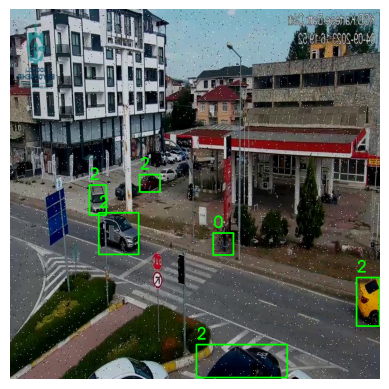

In [303]:
display_img(train_features[0], train_labels, calc_mean, calc_std)